In [2]:
!pip install rasterio
!pip install pandas
!pip install geopandas
!pip install numpy
!pip install opencv-python
!pip install matplotlib
!pip install shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#1. First. process the raster and shapes as per the acticle mentioned in the task

In [3]:
import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

Reading Raster with rasterio

In [4]:
raster_path = "T36UXV_20200406T083559_TCI_10m.jp2"
src = rasterio.open(raster_path, "r", driver="JP2OpenJPEG")
raster_img = reshape_as_image(src.read())
raster_meta = src.meta

Checking Raster shape and Meta

# shpnew.gpkg is a copy of Masks_T36UXV_20190427.shp where CRS was manually set to the CRS of the raster (for some reason changing it in the notebook didn't work)

In [5]:
train_df = gpd.read_file("shpnew.gpkg")

# let's remove rows without geometry
train_df = train_df[~train_df.geometry.is_empty & train_df.geometry.notna()]

train_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  after removing the cwd from sys.path.


,id,Data,Code,Descriptio,Comments,Image,geometry
0,None,None,2.0,branch of tree,None,T36UXV_20190427T083601,"MULTIPOLYGON (((689961.152 5497804.667, 690037..."
1,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"MULTIPOLYGON (((691518.623 5497815.456, 691645..."
2,None,None,2.0,brahch of tree,None,T36UXV_20190427T083601,"MULTIPOLYGON (((690017.383 5498399.293, 689968..."
3,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"MULTIPOLYGON (((689299.133 5498462.011, 689319..."
4,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"MULTIPOLYGON (((688152.716 5498615.331, 688249..."
...,...,...,...,...,...,...,...
931,None,None,1.0,color+ structure,None,T36UXV_20190427T083601,"MULTIPOLYGON (((690012.338 5435767.601, 689998..."
932,None,None,1.0,color+ structure,None,T36UXV_20190427T083601,"MULTIPOLYGON (((689303.051 5435318.547, 689365..."
933,None,None,1.0,color+ structure,None,T36UXV_20190427T083601,"MULTIPOLYGON (((690499.318 5436948.995, 690529..."
934,None,None,1.0,color+ structure,None,T36UXV_20190427T083601,"MULTIPOLYGON (((685438.102 5404906.207, 685405..."


In [6]:
# rasterize works with polygons that are in image coordinate system

def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for field/not_filed segmentation.

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  import sys


Using rasterio reshape to plot an image in matplotlib

In [7]:
#bin_mask_meta = src.meta.copy()
#bin_mask_meta.update({'count': 1})
#with rasterio.open("train.jp2", 'w', **bin_mask_meta) as dst:
#    dst.write(mask * 255, 1)

In [8]:
np.unique(mask)

array([0, 1], dtype=uint8)

# 2. Data Augmentation

# Let's split the large image into patches of 256x256

In [9]:
masks = []
#empty_masks = []

rasters = []
#empty_rasters = []

for i in range(0, len(mask) - 256, 64):
    for j in range(0, len(mask) - 256, 64):
      m = mask[i: i + 256, j: j + 256]
      r = raster_img[i: i + 256, j: j + 256]
      _, counts = np.unique(m, return_counts=True)
      if (counts[0] / counts.sum() < 0.99):
        masks.append(m)
        rasters.append(r)

In [10]:
len(masks)

2007

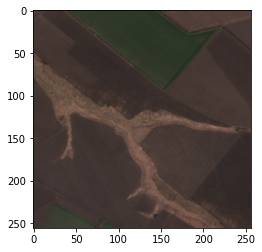

In [13]:
plt.imshow(rasters[112])

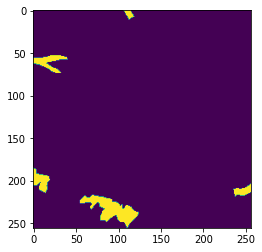

In [14]:
plt.imshow(masks[202])

# Add flipped images, add rotatated images

In [15]:
for i in range(len(masks)):
  masks.append(np.fliplr(masks[i]))
  rasters.append(np.fliplr(rasters[i]))

for i in range(len(masks)):
  masks.append(np.rot90(masks[i]))
  #masks.append(np.rot90(masks[-1]))
  #masks.append(np.rot90(masks[-1]))

  rasters.append(np.rot90(rasters[i]))
  #rasters.append(np.rot90(rasters[-1]))
  #rasters.append(np.rot90(rasters[-1]))

#Data Augmentation finished

In [16]:
len(masks), len(rasters)

(8028, 8028)

# 3. Training the model

#We will use U-net for this image segmentation problem

In [23]:
rasters[0].shape

(256, 256, 3)

In [24]:
# Building Unet by dividing encoder and decoder into blocks
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    activation = 'sigmoid'

    outputs = Conv2D(1, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [25]:
input_shape = (256, 256, 3)

In [26]:
from keras import backend as K
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

# The model uses adam optimizer, binary crossentropy loss, intersection over union as a metric

In [34]:
from tensorflow.keras.metrics import MeanIoU

model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 256, 256, 64  256        ['conv2d_38[0][0]']              
 ormalization)                  )                                                     

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(rasters, masks, test_size = 0.1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1)

In [100]:
len(masks)

803

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

In [38]:
v_data = (np.array(X_valid), np.array(y_valid))
history = model.fit(np.array(X_train), np.array(y_train), 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=20, 
                    validation_data=v_data, 
                    shuffle=False,
                    callbacks=[EarlyStopping(patience=10)])

model.save('model.hdf5')

Epoch 1/20
407/407 [==============================] - 378s 868ms/step - loss: 0.1263 - mean_io_u_1: 0.4863 - val_loss: 0.1172 - val_mean_io_u_1: 0.4868
Epoch 2/20
407/407 [==============================] - 345s 848ms/step - loss: 0.0981 - mean_io_u_1: 0.4863 - val_loss: 0.1526 - val_mean_io_u_1: 0.4868
Epoch 3/20
407/407 [==============================] - 354s 870ms/step - loss: 0.0889 - mean_io_u_1: 0.4863 - val_loss: 0.1642 - val_mean_io_u_1: 0.4868
Epoch 4/20
407/407 [==============================] - 355s 871ms/step - loss: 0.0804 - mean_io_u_1: 0.4863 - val_loss: 0.1151 - val_mean_io_u_1: 0.4868
Epoch 5/20
407/407 [==============================] - 355s 873ms/step - loss: 0.0713 - mean_io_u_1: 0.4863 - val_loss: 0.0999 - val_mean_io_u_1: 0.4868
Epoch 6/20
407/407 [==============================] - 355s 871ms/step - loss: 0.0604 - mean_io_u_1: 0.4863 - val_loss: 0.1062 - val_mean_io_u_1: 0.4868
Epoch 7/20
407/407 [==============================] - 347s 852ms/step - loss: 0.0496 - m

# Test masks

In [95]:
idx =  np.random.randint(len(y_test), size=24)

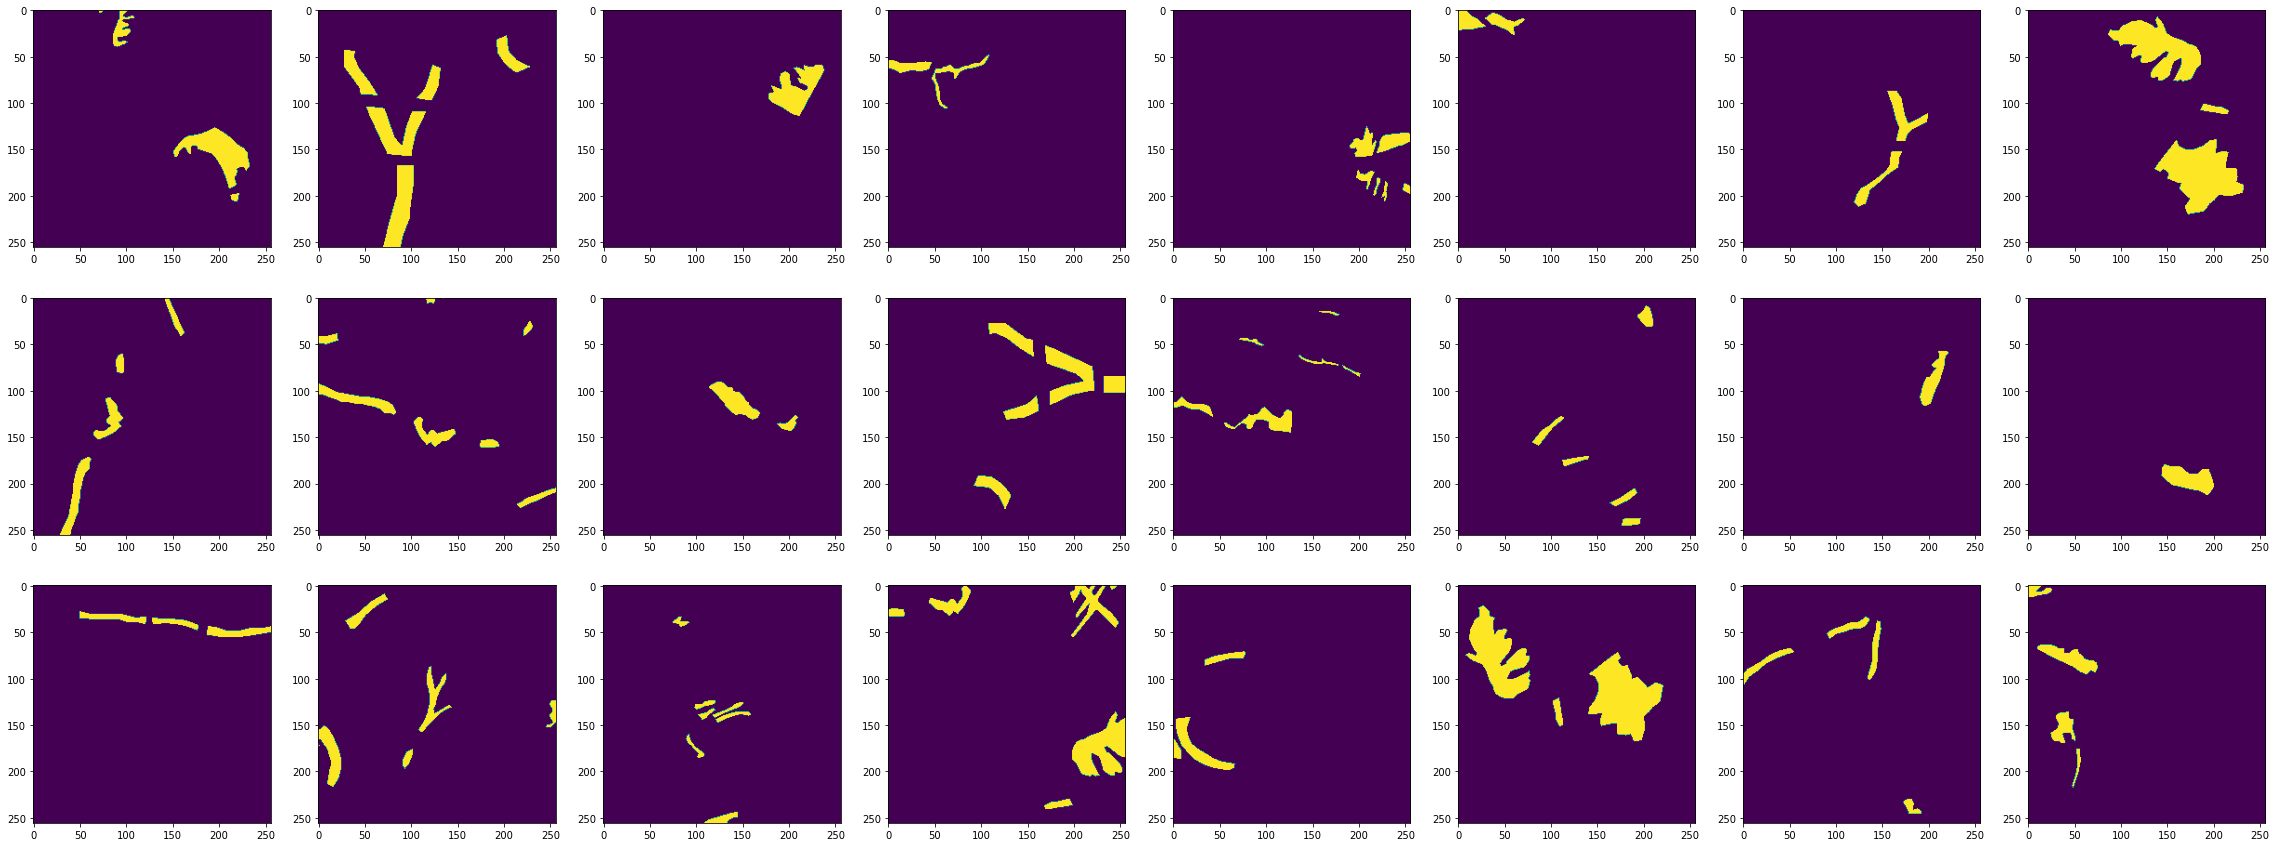

In [96]:
f, axarr = plt.subplots(3, 8)
f.set_size_inches(40, 15)
for i in range(len(idx)):
  axarr[i % 3, i % 8].imshow(y_test[idx[i]])

#Predicted masks

# We will use threshold of 0.5 to separate bright pixels from dark ones

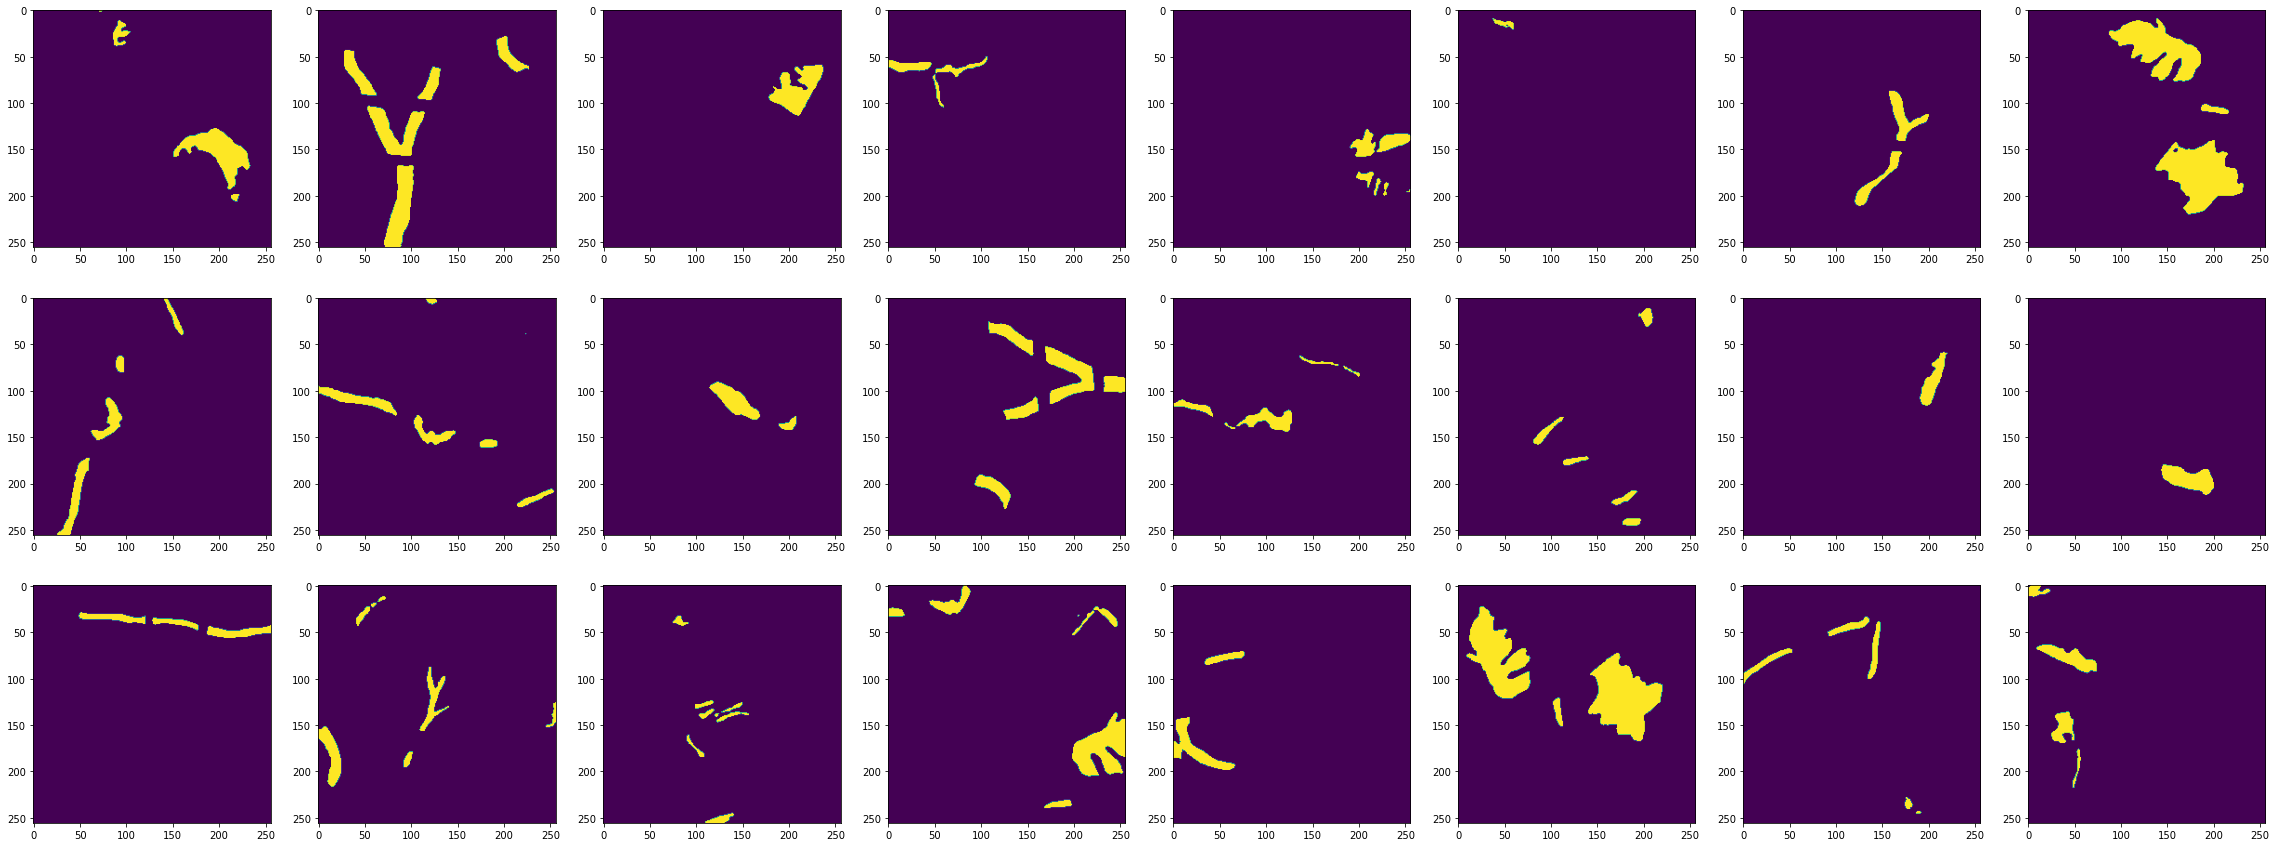

In [97]:
f, axarr = plt.subplots(3, 8)
f.set_size_inches(40, 15)
for i in range(len(idx)):
  axarr[i % 3, i % 8].imshow(pred[idx[i]][:, :, 0] > 0.5)

In [90]:
pred_bin = pred[:, :, :, 0] > 0.5

In [92]:
loss = MeanIoU(num_classes=2)
loss.update_state(y_test, pred_bin)

<tf.Variable 'UnreadVariable' shape=(2, 2) dtype=float32, numpy=
array([[16777216.,    56173.],
       [  146401.,  1307189.]], dtype=float32)>

In [93]:
loss.result().numpy()

0.9269469

In [103]:
%%writefile requirements.txt

Overwriting requirements.txt


# Mean IoU is over 92%!